## 处理数据

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 统计题目数量和最长的序列长度 

In [2]:
file_name = 'test.csv'

In [3]:
def str2list(line):
    return str.split(line.strip('\n').lstrip(',').rstrip(','),',')

In [4]:
max_len = 0
max_id = 0
min_id = 1e9

with open(file_name,'r') as file:
    for idx,line in enumerate(file):
        if idx%3==0:
            max_len = max(max_len,int(str2list(line)[0]))
        if idx%3==1:
            for qid in str2list(line):
                max_id = max(max_id,int(qid))
                min_id = min(min_id,int(qid))

In [5]:
print('max sequence length : %d'%max_len)
print('max qid : %d'%max_id)
print('min qid : %d'%min_id)

max sequence length : 1261
max qid : 110
min qid : 1


In [6]:
## 设置参数
sequence_len = 220
max_slen = 150
min_slen = 5

In [7]:
## 读取数据
qid_list = []
res_list = []
list_len = 0

with open(file_name,'r') as file:
    for idx,line in enumerate(file):
        if idx%3==1:
            tmp_list = str2list(line)
            list_len = len(tmp_list)
            start = 0
            while list_len > min_slen:
                if list_len>max_slen:
                    qid_list.append(tmp_list[start:start+150])
                    start+=150
                else:
                    qid_list.append(tmp_list[start:])
                    start = len(tmp_list)
                list_len = len(tmp_list)-start
        if idx%3==2:
            tmp_list = str2list(line)
            list_len = len(tmp_list)
            start = 0
            while list_len > min_slen:
                if list_len>max_slen:
                    res_list.append(tmp_list[start:start+150])
                    start+=150
                else:
                    res_list.append(tmp_list[start:])
                    start = len(tmp_list)
                list_len = len(tmp_list)-start

In [8]:
for idx,lst in enumerate(qid_list):
    if not len(lst)==len(res_list[idx]):
        print('error')

In [9]:
## 做one-hot嵌入
def qr2onehot(qid,rid):
    onehot_list = [0]*sequence_len
    idx = qid
    if int(rid) == 1:
        idx = qid+110
    onehot_list[idx-1] = 1
    return np.array(onehot_list)

In [10]:
## 只返回index
def qr2onehot_index(qid,rid):
    idx = qid
    if int(rid) == 1:
        idx = qid+110
    return idx

In [11]:
inputs = []
input_indexs = []
for idx,lst in enumerate(qid_list):
    res_tmp = res_list[idx]
    tmp = []
    tmp_indxs = []
    for qidx,qid in enumerate(lst):
        if qidx == len(lst)-1:
            continue
        tmp.append(qr2onehot(int(qid),int(res_tmp[qidx])))
        tmp_indxs.append(qr2onehot_index(int(qid),int(res_tmp[qidx])))
    inputs.append(np.array(tmp))
    input_indexs.append(np.array(tmp_indxs))

In [12]:
inputs = np.array(inputs)
inputs_indexs = np.array(input_indexs)

In [13]:
inputs.shape

(3264,)

In [14]:
## 填充数据集
inputs = keras.preprocessing.sequence.pad_sequences(inputs, maxlen=max_slen, dtype='int32',
    padding='post',value=-1)
inputs_indexs = keras.preprocessing.sequence.pad_sequences(inputs_indexs, maxlen=max_slen, dtype='int32',
    padding='post',value=0)
print(inputs_indexs.shape)
inputs.shape

(3264, 150)


(3264, 150, 220)

In [15]:
inputs_indexs[0]

array([  1, 111, 111, 111,   1,   1,   1,   1, 111, 111, 111, 111, 111,
       111,   1, 111, 111, 111, 111, 111, 111, 111,   1, 111, 111, 111,
         1, 111, 111,   1,   1, 111, 111, 111, 111, 111,   1, 111,   1,
        31,  31, 141,  31,  31, 141,  31,  68,  68, 178, 178,  68,  68,
       178, 111, 111, 111,   1, 132,  31,  31, 141,  31, 141,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [16]:
targets = []
targets_ids = []
for idx,item in enumerate(res_list):
    targets.append(np.array(item[1:]))
    qid_index = np.array(qid_list[idx][1:])
    for idx,_ in enumerate(qid_index):
        qid_index[idx]=int(qid_index[idx])-1
    targets_ids.append(np.array(qid_index))
targets = np.array(targets)
targets_ids = np.array(targets_ids)

In [17]:
print(targets_ids[1])
print(targets[1])
print(inputs_indexs[1])

['7' '3' '4' '3' '4' '3' '4' '3' '4' '3' '8' '3' '8' '3' '6' '3' '6' '9'
 '9' '9' '9' '9' '11' '12' '13' '11' '12' '13' '5' '8' '5' '8' '3' '14'
 '3' '15' '16' '16' '16' '16' '3' '7' '3' '7' '3' '7' '3' '7' '3' '4' '3'
 '4' '3' '4' '3' '8' '3' '8' '17' '23' '20' '20' '20' '20' '20' '23' '23'
 '23' '23' '23' '18' '22' '21' '22' '21' '22' '24' '22' '24' '22' '24'
 '22' '21' '22' '21' '22' '24' '22' '21' '22' '21' '22' '19' '17' '23'
 '23' '23' '23' '23' '23' '21' '21' '21' '21' '21' '36' '33' '33' '33'
 '33' '33' '33' '33' '33' '33' '33' '33' '33' '79' '89' '79' '35' '79'
 '79' '35' '34' '73' '73' '73' '73' '73' '73' '59' '59' '59' '59' '59'
 '59' '59' '20' '20' '20' '20' '20' '20' '58' '40' '40' '40']
['0' '1' '1' '0' '0' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '0' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '0' '1' '1' '1' '0' '0' '1' '1' '1' '1' '1' '1' '0' '0' '1' '1' '0' '0'
 '1' '1' '1' '1' '1' '1' '0' '0' '1' '1' '1' '0' '0' '0' '1' '1' '1' '1

In [18]:
targets = keras.preprocessing.sequence.pad_sequences(targets, maxlen=max_slen, dtype='int32',
    padding='post',value=-1)
targets_ids = keras.preprocessing.sequence.pad_sequences(targets_ids, maxlen=max_slen, dtype='int32',
    padding='post',value=0)
targets.shape

(3264, 150)

## 验证数据是否正确

In [19]:
for idx,item in enumerate(inputs):
    if not len(item) == len(qid_list[idx]):
        print('error')
        print('%d %d'%(len(item),len(qid_list[idx])))
        break

error
150 64


In [20]:
print(inputs.shape)
print(targets.shape)

(3264, 150, 220)
(3264, 150)


In [21]:
targets_ids[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, 30, 30, 30, 30, 30, 30, 30, 67, 67, 67, 67, 67, 67,
       67,  0,  0,  0,  0, 21, 30, 30, 30, 30, 30, 30,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

In [22]:
## hyperparameter

embedding_dim = 200
hidden_dim = 256
class_dim = 110

In [23]:
def loss_fun(y_true,y_pred):
    mask = tf.where(y_true>=0)
    logits = tf.gather_nd(y_pred,mask)
    truth = tf.gather_nd(y_true,mask)
    return keras.losses.binary_crossentropy(truth,logits,from_logits=False)

In [24]:
#精确率评价指标
def metric_precision(y_true,y_pred):   
    mask = tf.where(y_true>=0)
    y_pred = tf.gather_nd(y_pred,mask)
    y_true = tf.gather_nd(y_true,mask)
    TP=tf.reduce_sum(y_true*tf.round(y_pred))
    TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
    FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    precision=TP/(TP+FP)
    return precision

#召回率评价指标
def metric_recall(y_true,y_pred):  
    mask = tf.where(y_true>=0)
    y_pred = tf.gather_nd(y_pred,mask)
    y_true = tf.gather_nd(y_true,mask)
    TP=tf.reduce_sum(y_true*tf.round(y_pred))
    TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
    FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    recall=TP/(TP+FN)
    return recall

#F1-score评价指标
def metric_F1score(y_true,y_pred): 
    mask = tf.where(y_true>=0)
    y_pred = tf.gather_nd(y_pred,mask)
    y_true = tf.gather_nd(y_true,mask)
    TP=tf.reduce_sum(y_true*tf.round(y_pred))
    TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
    FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    precision=TP/(TP+FP)
    recall=TP/(TP+FN)
    F1score=2*precision*recall/(precision+recall)
    return F1score

In [25]:
from tensorflow.keras.utils import *

def build_model(sequence_len,features_len):
    x = keras.Input(shape=(sequence_len,),name='input_x')
    indexs = keras.Input(shape=(sequence_len,),name='indexs')
    targets = keras.Input(shape=(sequence_len,),name='targets')
    embeded_x = layers.Embedding(input_dim=features_len+1, output_dim=embedding_dim, input_length=max_slen,mask_zero=True,name='embeding')(x)
    lstm_x =  layers.LSTM(hidden_dim, return_sequences=True,name='lstm')(embeded_x)
    predict_x = layers.Dense(class_dim, activation='sigmoid',name = 'predict')(lstm_x)
    tmp_x = tf.gather_nd(predict_x,tf.where(tf.one_hot(tf.cast(indexs,dtype=tf.int32),class_dim)>0))
    pred_1d = tf.reshape(tmp_x,[-1,sequence_len])
    pred_1d = layers.Lambda(lambda x:x,name='pred')(pred_1d)
    last_skills = tf.gather_nd(predict_x,tf.where(tf.one_hot((tf.reduce_sum(tf.cast(targets>=0,tf.int32),axis=1))-1,sequence_len)>0))
    last_pred  = tf.gather_nd(pred_1d,tf.where(tf.one_hot((tf.reduce_sum(tf.cast(targets>=0,tf.int32),axis=1))-1,sequence_len)>0))
    model = keras.Model(inputs=(x,indexs,targets),outputs=(pred_1d,last_skills,last_pred))
   
    model.compile(optimizer=keras.optimizers.Adam(0.01),
                  loss= {'pred':loss_fun},
                  metrics=[
                            metric_precision,
                            metric_recall,
                            metric_F1score]
                          )
    return model

In [26]:
input_data = tf.data.Dataset.from_tensor_slices(({'input_x':inputs_indexs,'indexs':targets_ids,'targets':targets},targets))
input_data = input_data.shuffle(buffer_size=256).batch(64).repeat()

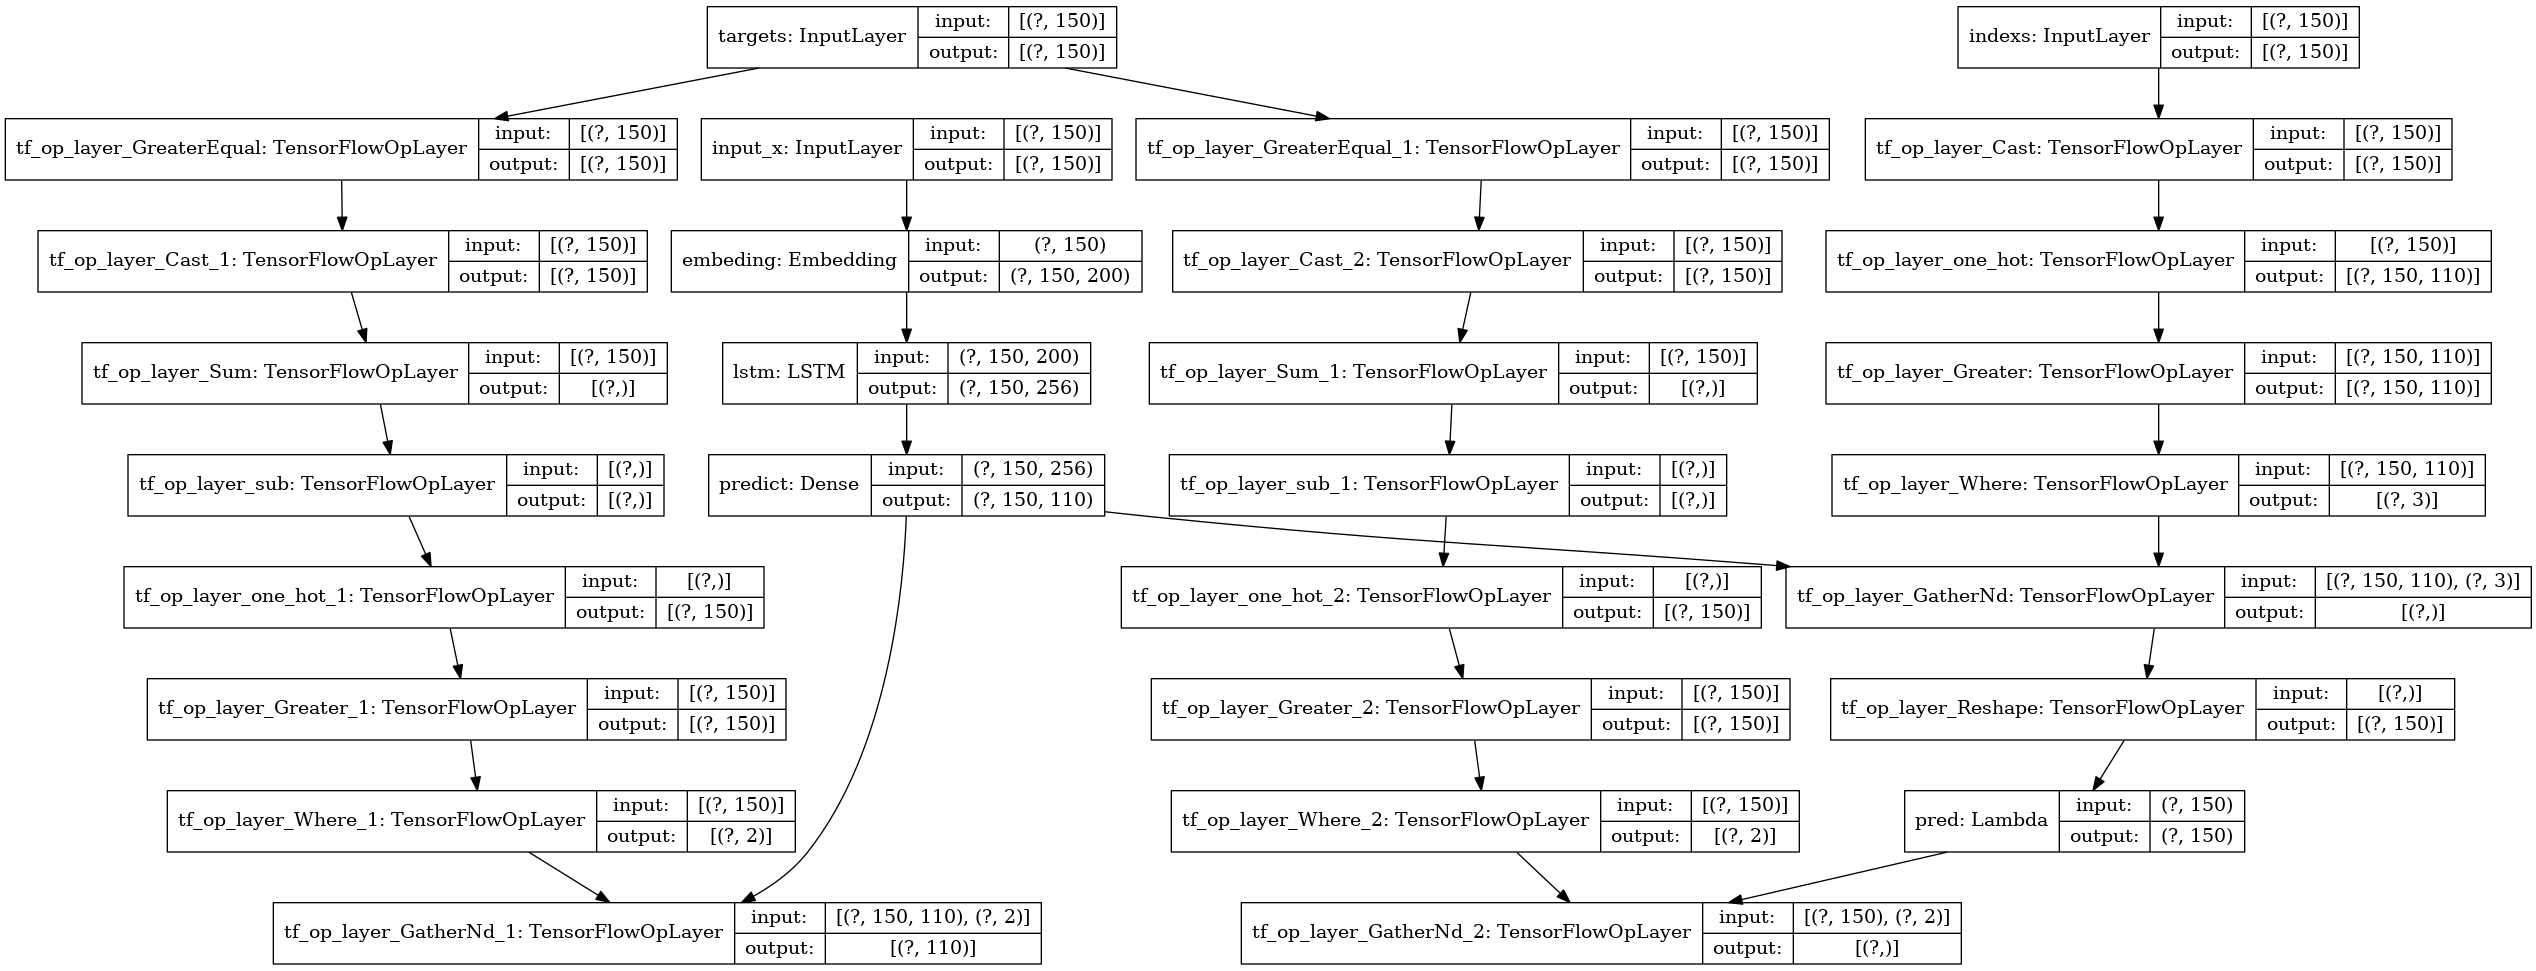

In [27]:
model = build_model(150,220)
keras.utils.plot_model(model,show_layer_names=True,show_shapes=True)

In [28]:
check_callback = keras.callbacks.ModelCheckpoint(
    filepath='./models/dkt_epoch_{epoch}_pre_{pred_metric_precision}.h5',
    save_best_only=True,
    monitor='loss',
    verbose=1
)

In [ ]:
model.fit(input_data, epochs=500, steps_per_epoch=100,callbacks=[check_callback],verbose=0)dropout=